<h1><center>NUS Statistics Society</center><h1>
<h1><center>Machine Learning Study Group Project</center><h1>

<h4><center>Chan Guan Hao</center><h4>

<h4><center>Wong Jia Hwee</center><h4>

<h4><center>Zi Hao</center><h4>

<h4><center>Hemashree</center><h4>

# Financial Distress

In this project, given some data, we aim to predict if a company will be financially distressed. We shall model this problem as a classification problem, whereby companies that are regarded as financially healthy (with a raw value of > -0.50) will be classified as 0, and otherwise as financially distressed and classified as 1.

This data set is imbalanced (there are 136 financially distressed companies against 286 healthy ones i.e., 136 firm-year observations are financially distressed while 3546 firm-year observations are healthy). The kaggle author recommends the use of F-score as the performance evaluation criterion.

My learning objective for this project is to apply pipelining, practice a proper machine learning workflow and data preprocessing skills.

It should be noted that 30% (Kaggle criteria) of this data set should be randomly assigned as hold-out test set so the remaining 70% is used for feature selection and model selection i.e., train set.

The performance metric we will be using here is the Recall Score, complemented by F1 Score and ROC AUC Score.

Recall is a good metric when there is a high cost associated with False Negatives, which in our case is wrongly predicting a potentially financially distressed company to be financially healthy. Therefore, instead of F1 score, recall will be our main performance metric.

F1 places a balance between Precision and Recall which can be helpful as well.

In [ ]:
# Import Libraries

import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import imblearn
import lightgbm as lgb

from numpy import argmax

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import plot_confusion_matrix,recall_score, f1_score, roc_auc_score, plot_roc_curve, plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# DIRECTORIES

filename = "Financial Distress.csv"
CURR_DIR = "/content/drive/My Drive/ML Study Group Project/Jia Hwee/"

In [ ]:
os.listdir()

['.config', 'drive', 'sample_data']

In [ ]:
df = pd.read_csv(CURR_DIR + filename) 

In [ ]:
print(df.shape)
df.head()

# There are 3672 rows and 86 columns

(3672, 86)


,Company,Time,Financial Distress,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,...,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
0,1,1,0.010636,1.2810,0.022934,0.87454,1.21640,0.060940,0.188270,0.52510,0.018854,0.182790,0.006449,0.85822,2.00580,0.125460,6.9706,4.6512,0.050100,2.1984,0.018265,0.024978,0.027264,1.41730,9.5554,0.148720,0.66995,214.760,12.641,6.4607,0.043835,0.204590,0.35179,8.3161,0.28922,0.76606,2.5825,77.400,0.026722,1.63070,...,0.180160,1.50060,0.026224,7.0513,1174.90,5.3399,0.85128,12.837,0.061737,0.180900,209.87,-0.582550,0.47101,0.109900,0.000000,0.000000,0.22009,7.1241,15.3810,3.2702,17.8720,34.6920,30.087,12.8,7991.4,364.9500,15.8,61.476,4.0,36.0,85.437,27.07,26.102,16.000,16.0,0.2,22,0.060390,30,49
1,1,2,-0.455970,1.2700,0.006454,0.82067,1.00490,-0.014080,0.181040,0.62288,0.006423,0.035991,0.001795,0.85152,-0.48644,0.179330,4.5764,3.7521,-0.014011,2.4575,0.027558,0.028804,0.041102,1.18010,7.2952,0.056026,0.67048,38.242,12.877,5.5506,0.265480,0.150190,0.41763,9.5276,0.41561,0.81699,2.6033,95.947,0.007580,0.83754,...,0.046857,1.00950,0.007864,4.6022,1062.50,3.7389,0.94397,12.881,-0.000565,0.056298,250.14,-0.474770,0.38599,0.369330,0.000000,0.000000,0.00000,7.4166,7.1050,14.3210,18.7700,124.7600,26.124,11.8,8322.8,0.1896,15.6,24.579,0.0,36.0,107.090,31.31,30.194,17.000,16.0,0.4,22,0.010636,31,50
2,1,3,-0.325390,1.0529,-0.059379,0.92242,0.72926,0.020476,0.044865,0.43292,-0.081423,-0.765400,-0.054324,0.89314,0.41220,0.077578,11.8900,2.4884,0.028077,1.3957,0.012595,0.068116,0.014847,0.81652,7.1204,0.065220,0.84827,-498.390,13.225,16.2540,0.416570,0.074149,0.36723,9.3513,0.50356,0.91962,1.4931,144.670,-0.066483,0.95579,...,-0.579760,0.57832,-0.064373,11.9880,651.15,10.9340,0.93478,12.909,0.041625,0.047562,280.55,-1.000000,0.48844,0.053299,0.003785,0.005191,0.00000,3.6373,7.0213,1.1538,9.8951,6.4467,30.245,10.3,8747.0,11.9460,15.2,20.700,0.0,35.0,120.870,36.07,35.273,17.000,15.0,-0.2,22,-0.455970,32,51
3,1,4,-0.566570,1.1131,-0.015229,0.85888,0.80974,0.076037,0.091033,0.67546,-0.018807,-0.107910,-0.065316,0.89581,0.99490,0.141120,6.0862,1.6382,0.093904,2.0588,0.011601,0.094385,0.014415,0.90391,7.9828,0.125160,0.80478,-75.867,13.305,8.8950,0.083774,0.054098,0.54360,7.0909,0.67133,0.93701,2.3533,219.750,-0.017000,0.38335,...,-0.150130,0.64508,-0.017731,6.1114,703.04,5.7028,0.87484,13.094,0.108400,0.101350,413.74,0.565000,0.34408,0.073356,0.000037,0.000045,0.00000,5.1442,9.9099,2.0408,-1.4903,-21.9070,34.285,11.5,9042.5,-18.7480,10.4,47.429,4.0,33.0,54.806,39.80,38.377,17.167,16.0,5.6,22,-0.325390,33,52
4,2,1,1.357300,1.0623,0.107020,0.81460,0.83593,0.199960,0.047800,0.74200,0.128030,0.577250,0.094075,0.81549,3.01470,0.185400,4.3938,1.6169,0.239210,3.0311,0.006814,0.079346,0.008876,1.02510,4.7463,0.266020,0.76770,1423.100,11.575,17.4880,0.620770,0.046907,0.56963,9.4861,0.68143,0.94242,4.1296,222.650,0.131230,0.25301,...,0.607660,0.25782,0.131380,4.4151,2465.40,4.1408,0.73398,11.396,0.250310,0.222370,315.34,-0.060101,0.20242,1.229100,-0.002491,-0.002980,0.22688,7.1241,15.3810,3.2702,17.8720,34.6920,30.087,12.8,7991.4,364.9500,15.8,61.476,4.0,36.0,85.437,27.07,26.102,16.000,16.0,0.2,29,1.251000,7,27


## Train-Val-Test Split

We have to use `stratify` in our train-val-test split due to the imbalance of the data to ensure the distribution of both classes in each dataset is about the same.

https://machinelearningmastery.com/cross-validation-for-imbalanced-classification/



In [ ]:
x = pd.DataFrame(df.loc[:,df.columns != 'Financial Distress'])
y = pd.DataFrame(df.loc[:,'Financial Distress'])

In [ ]:
def binarize_response(input):
  if input > -0.5:
    return 0
  elif input <= -0.5:
    return 1

In [ ]:
y['Financial Distress'] = y['Financial Distress'].map(lambda x : binarize_response(x))

In [ ]:
# Train-Test Split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 24, test_size = 0.3, stratify=y) 

In [ ]:
# Train-Val Split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state = 24, test_size = 0.3, stratify=y_train) 

In [ ]:
print(x_train.shape) # 1799 rows
print(x_val.shape) # 771 rows
print(x_test.shape) # 1102 rows

(1799, 85)
(771, 85)
(1102, 85)


In [ ]:
print(y_train['Financial Distress'].value_counts())
print(y_val['Financial Distress'].value_counts())

0    1732
1      67
Name: Financial Distress, dtype: int64
0    743
1     28
Name: Financial Distress, dtype: int64


There is a good distribution of the minority class in both the train set and validation set.

## Exploratory Data Analysis

In [ ]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1799 entries, 524 to 1041
Data columns (total 85 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Company  1799 non-null   int64  
 1   Time     1799 non-null   int64  
 2   x1       1799 non-null   float64
 3   x2       1799 non-null   float64
 4   x3       1799 non-null   float64
 5   x4       1799 non-null   float64
 6   x5       1799 non-null   float64
 7   x6       1799 non-null   float64
 8   x7       1799 non-null   float64
 9   x8       1799 non-null   float64
 10  x9       1799 non-null   float64
 11  x10      1799 non-null   float64
 12  x11      1799 non-null   float64
 13  x12      1799 non-null   float64
 14  x13      1799 non-null   float64
 15  x14      1799 non-null   float64
 16  x15      1799 non-null   float64
 17  x16      1799 non-null   float64
 18  x17      1799 non-null   float64
 19  x18      1799 non-null   float64
 20  x19      1799 non-null   float64
 21  x20      179

In [ ]:
x_train.describe()

,Company,Time,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,...,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
count,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1.799000e+03,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1.799000e+03,1799.000000,1799.000000,1.799000e+03,1799.000000,1.799000e+03,1799.000000,1799.000000,1799.000000,1799.000000,1.799000e+03,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1.799000e+03,1799.000000,1799.000000,1.799000e+03,1.799000e+03,1799.000000,1799.000000,1799.000000,...,1799.000000,1799.000000,1799.000000,1.799000e+03,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000
mean,185.778766,7.602001,1.400727,0.128138,0.613642,8.669234e-01,0.154391,0.110126,0.799738,130.694506,0.326694,0.135505,0.638837,1.012193e+05,0.386358,2.428557,7.093707e+03,-32.376825,3.207024e+03,0.042016,80.399904,0.105443,1.437451,2.108542e+01,0.272678,0.528710,968.653136,13.317398,1.524377,0.195457,0.084931,0.354326,2.155319e+05,256.771527,0.861405,4.321818e+03,1.690539e+04,0.235757,0.324184,8.112346,...,4.261501,0.159028,0.303081,2.415028e+03,2467.207654,2.104375,0.727322,12.957626,-30.074062,0.206954,3221.671249,0.009069,0.235880,0.944921,-0.009229,-4.393099,0.113561,2.631725,3.377402,1.210098,-0.825729,30.804463,28.201782,11.459359,16025.838799,22.448646,17.883832,23.313644,1.941570,30.377016,86.555346,93.015616,90.161229,17.809200,15.220454,-2.663379,19.856587,1.076274,13.035575,32.930517
std,117.042475,4.066401,1.566974,0.121433,0.178974,5.670441e-01,0.126415,0.212502,1.267098,5001.163015,0.361565,0.140008,0.201347,1.232691e+06,0.178974,2.458923,1.133923e+05,921.509374,8.494360e+04,0.048063,3279.686686,0.227492,0.900718,3.238247e+02,0.170922,0.182292,1317.385982,1.618810,343.748076,0.265888,0.094790,0.170684,5.937993e+06,8119.913805,0.143104,1.062114e+05,7.096594e+05,0.265777,0.560646,296.562104,...,81.031115,0.759726,0.902183,5.963416e+04,2108.886779,2.180237,0.170922,1.753884,859.949691,0.130940,10908.434131,0.429900,0.138026,27.940978,0.026827,185.596002,0.089114,3.910479,6.962491,8.719531,12.271742,43.334406,6.182626,0.963596,10112.527124,99.045670,7.144555,17.805764,1.456570,3.659794,16.287471,65.155701,64.860847,2.066238,2.882555,8.264642,7.436008,1.782173,9.507380,13.937456
min,1.000000,1.000000,0.175260,-0.169500,0.016135,5.350000e-07,-0.269790,-0.627750,0.035160,-9332.000000,-3.611200,-0.256480,0.022917,-1.610000e+05,0.032101,0.016400,1.190000e-05,-30618.000000,0.000000e+00,0.000287,0.000000,0.000927,0.000003,8.300000e-07,-0.553850,0.016135,-3374.600000,8.255600,-8408.400000,-0.499440,0.000000,0.002082,0.000000e+00,0.018618,0.049372,4.560000e-05,0.000000e+00,-0.634510,0.000000,0.000676,...,-56.719000,-4.926300,-1.074900,1.640100e-02,547.970000,0.016400,0.000000,0.000000,-28982.000000,-0.225220,0.012658,-1.000000,0.000000,-0.998710,-0.279260,-7872.000000,-0.235650,-7.714000,-11.824000,-25.736000,-21.411000,-21.907000,15.916000,10.300000,7941.800000,-58.122000,10.400000,-10.665000,0.000000,22.000000,54.806000,24.318000,23.776000,15.250000,12.000000,-20.200000,1.000000,-0.489780,1.000000,2.000000
25%,84.500000,4.000000,0.951070,0.047088,0.498595,5.530250e-01,0.068130,-0.026344,0.440110,0.052701,0.151285,0.033531,0.501565,1.822950e+00,0.253255,0.994390,2.248850e+00,0.086347,1.659350e+00,0.013227,0.012863,0.024420,0.902945,1.915100e+00,0.

Observations:

- There are 85 columns/features.
- The columns are mostly float types, with a small few integer types. 
- There are no missing values.
- Each column has different means and variances. Standard scaling will be required during preprocessing.
- There are too many unknown columns to carry out much data preprocessing. We might have to find other ways such as through modelling first to gather more information about the data.

0    1732
1      67
Name: Financial Distress, dtype: int64


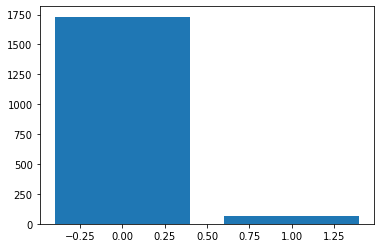

In [ ]:
plt.bar([0,1],y_train['Financial Distress'].value_counts())
print(y_train['Financial Distress'].value_counts())

The data is extremely inbalanced, with a very large number (1733) of financially healthy examples, and a very small number (66) of financially distressed examples. The number of financially distressed examples constitutes only 3.8% of the financially healthy examples.

https://machinelearningmastery.com/cross-validation-for-imbalanced-classification/

## Preprocessing I

Let's first remove the `Company` and `Time` column. Then, we shall standard scale the data.

We are assuming that `Company` and `Time` do not affect our analysis, and that the other features represent the state of a particular company at that point in time with a resulting financial status.

In [ ]:
class DropCompanyAndTime(BaseEstimator, TransformerMixin):

  def __init__(self):
    self.new_df = None

  def fit(self, x, y=None):
    return self

  def transform(self, x , y=None):
    x2 = x.drop(['Company','Time'], axis=1)
    self.new_df = x2
    return x2

In [ ]:
drop_coy_and_time = DropCompanyAndTime()
std_scaler = StandardScaler()

In [ ]:
prepro_1_pipeline = Pipeline([
    ('drop_company_and_time_columns', drop_coy_and_time),
    ('std_scaler', std_scaler)
])

## Baseline Model

We shall use a basic Support Vector Classifier and basic Random Forest as our baseline models. 

Since the dataset has many columns, it is difficult to do EDA on the dataset. We can utilize feature importance of random forest to help us.

### Baseline Support Vector Classifier

In [ ]:
baseline_svc = SVC() # Radial Basis Function Kernel by default

In [ ]:
baseline_svc_pipeline = Pipeline([
    ('preprocessing_1', prepro_1_pipeline),
    ('baseline_rf', baseline_svc)
])

In [ ]:
baseline_svc_pipeline.fit(x_train,y_train)

baseline_svc_train_preds = baseline_svc_pipeline.predict(x_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Recall Score: 0.05970149253731343
Training F1 Score: 0.11267605633802817
Training ROC AUC Score: 0.5298507462686567


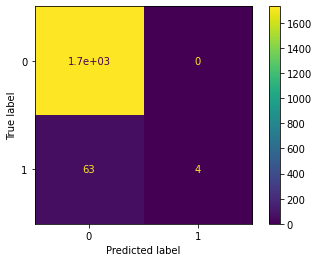

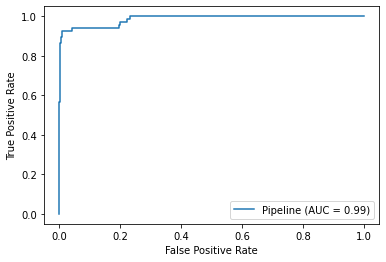

In [ ]:
print("Training Recall Score:", recall_score(y_train,baseline_svc_train_preds))
print("Training F1 Score:", f1_score(y_train,baseline_svc_train_preds))
print("Training ROC AUC Score:", roc_auc_score(y_train,baseline_svc_train_preds))
plot_confusion_matrix(baseline_svc_pipeline, x_train,y_train)
plot_roc_curve(baseline_svc_pipeline, x_train,y_train)

In [ ]:
baseline_svc_val_preds = baseline_svc_pipeline.predict(x_val)

Validation Recall Score: 0.0
Validation F1 Score: 0.0
Validation ROC AUC Score: 0.5


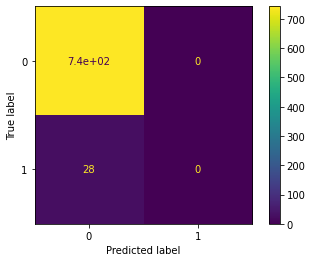

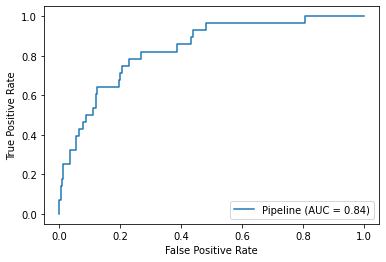

In [ ]:
print("Validation Recall Score:", recall_score(y_val,baseline_svc_val_preds))
print("Validation F1 Score:", f1_score(y_val,baseline_svc_val_preds))
print("Validation ROC AUC Score:", roc_auc_score(y_val,baseline_svc_val_preds))
plot_confusion_matrix(baseline_svc_pipeline, x_val,y_val)
plot_roc_curve(baseline_svc_pipeline, x_val, y_val)

The baseline SVC performed very badly, which 0 validation recall score and 0 validation f1 score. The validation ROC curve also showed the poor performance of the baseline SVC with an AUC score of 0.5.

The confusion matrix also showed that all the financially distressed examples are classified as financially healthy in the validation set.



### Baseline Random Forest

In [ ]:
baseline_rf = RandomForestClassifier(n_jobs=-1)

In [ ]:
baseline_rf_pipeline = Pipeline([
    ('preprocessing_1', prepro_1_pipeline),
    ('baseline_rf', baseline_rf)
])

In [ ]:
baseline_rf_pipeline.fit(x_train,y_train)

baseline_rf_train_preds = baseline_rf_pipeline.predict(x_train)

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Training Recall Score: 0.9850746268656716
Training F1 Score: 0.9924812030075187
Training ROC AUC Score: 0.9925373134328358


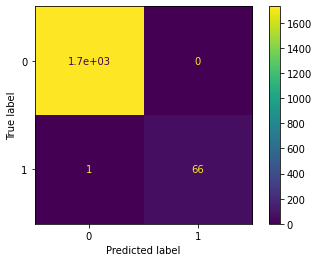

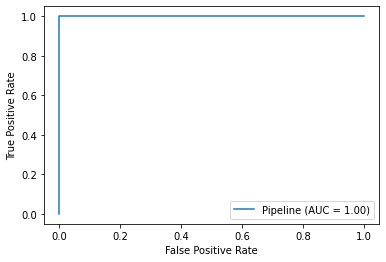

In [ ]:
print("Training Recall Score:", recall_score(y_train,baseline_rf_train_preds))
print("Training F1 Score:", f1_score(y_train,baseline_rf_train_preds))
print("Training ROC AUC Score:", roc_auc_score(y_train,baseline_rf_train_preds))
plot_confusion_matrix(baseline_rf_pipeline, x_train,y_train)
plot_roc_curve(baseline_rf_pipeline, x_train,y_train)

The baseline random forest model is clearly overfitting to the training set. There is only 1 false negative, and the training recall score is 0.985. Let's see how it performs on the validation set.

In [ ]:
baseline_rf_val_preds = baseline_rf_pipeline.predict(x_val)

Validation Recall Score: 0.10714285714285714
Validation F1 Score: 0.19354838709677416
Validation ROC AUC Score: 0.5535714285714286


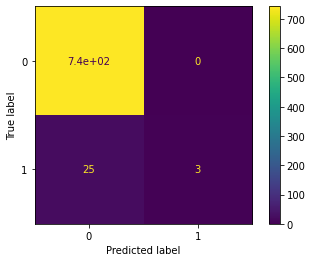

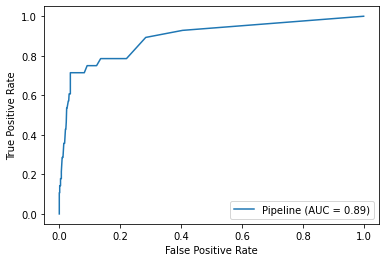

In [ ]:
print("Validation Recall Score:", recall_score(y_val,baseline_rf_val_preds))
print("Validation F1 Score:", f1_score(y_val,baseline_rf_val_preds))
print("Validation ROC AUC Score:", roc_auc_score(y_val,baseline_rf_val_preds))
plot_confusion_matrix(baseline_rf_pipeline, x_val,y_val)
plot_roc_curve(baseline_rf_pipeline, x_val, y_val)

The baseline random forest obtained a very low validation recall score and validation f1 score. Although the baseline random forest is marginally better than the baseline SVC, its performance is still very poor.

The baseline random forest managed to predict only 3 true positives out of 28 can be very costly.

These are expected as the data is extremely imbalanced. 

#### Baseline Random Forest Feature Importance I

In [ ]:
x_train

,Company,Time,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,...,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
524,49,7,1.55490,0.262860,0.48014,0.749550,0.336360,0.247760,1.10630,0.350690,0.505630,0.357840,0.694280,22.1990,0.51986,0.92359,1.9084,0.448760,2.7679,0.058427,0.020215,0.130850,1.07960,3.099200,0.491840,0.44651,1784.600,12.812,3.02520,0.347670,0.033627,0.493990,4.2247,0.65905,0.92996,5.4468,188.640,0.378610,0.064684,0.077950,...,1.086900,0.476600,0.547470,0.92587,3529.40,0.85890,0.50816,12.524,0.479680,0.368660,877.930,0.054355,0.137610,0.343420,0.000000,0.000000,0.184170,-0.075348,-0.23637,-3.02660,5.7748,-20.9820,15.916,10.40,9667.3,4.7909,25.40,41.5980,0.0000,28.000,79.951,66.120,59.471,18.000,12.000,-13.4000,29,2.429400,16,43
590,54,3,0.99153,0.198450,0.82798,0.772930,0.181520,-0.006769,0.66571,0.256750,1.153600,0.096267,0.792190,4.0614,0.17202,4.81320,1.8831,0.234850,2.3830,0.013176,0.057825,0.016491,0.97569,9.459100,0.270960,0.79896,2881.600,12.604,-114.18000,0.386760,0.029016,0.531880,8.7823,0.68813,0.96496,3.2687,191.170,0.250510,0.168670,0.017047,...,2.428600,-0.039352,0.239680,4.81320,2497.80,4.64450,0.72904,12.346,0.246110,0.209430,657.350,0.024488,0.236460,0.549530,-0.003612,-0.004672,0.119960,3.637300,7.02130,1.15380,9.8951,6.4467,30.245,10.30,8747.0,11.9460,15.20,20.7000,0.0000,35.000,120.870,36.070,35.273,17.000,15.000,-0.2000,29,1.397800,14,41
2956,303,14,0.27602,-0.011747,0.32039,0.031295,-0.011751,-0.146610,0.23114,-0.375350,-0.017285,-0.043343,0.055894,-28.6130,0.67961,0.47142,1.2205,-0.375480,4.9024,0.001689,0.013123,0.008341,0.55990,0.034138,0.007083,0.20250,-16.289,13.508,-0.21347,0.024126,0.117890,0.046805,2.1268,1.49560,0.63205,4.9374,294.970,-0.210160,0.173460,0.053969,...,-0.012814,-0.215720,-0.036664,0.49102,942.43,0.29796,0.99292,10.044,-0.001521,0.000222,575.330,-0.022551,0.006338,0.016877,0.000000,0.000000,0.000000,-1.586300,-7.50460,12.14500,-20.2290,28.2860,30.023,11.00,34501.0,-32.2090,11.90,13.8710,1.0000,29.000,91.700,227.500,214.500,21.000,20.500,8.6000,15,-0.060104,5,10
3065,325,4,0.80500,0.293900,0.68815,1.530200,0.359980,-0.128450,0.34494,0.192070,0.942440,0.017983,0.530260,9.8714,0.31185,2.20660,14.2800,0.235250,7.6893,0.100520,0.023831,0.152600,2.88580,4.133000,0.255850,0.65872,1101.800,11.407,-11.91300,0.213330,0.029431,0.227220,102000.0000,0.14849,0.95723,10.3330,25.209,0.554260,0.094376,0.065690,...,0.793800,-0.411900,0.427090,2.20660,1169.10,2.11230,0.74415,11.833,0.249580,0.391510,1092.700,0.075028,0.148090,0.461760,0.000467,0.000305,0.132700,4.139600,7.98420,1.44940,6.0999,-3.0045,31.592,10.70,8845.5,1.7150,13.60,29.6090,1.3333,34.333,98.851,37.313,36.308,17.056,15.333,1.7333,19,0.067417,17,40
1549,141,8,1.04630,0.063711,0.88178,1.365400,0.147760,0.038867,0.94363,0.046661,0.538940,0.046783,0.878390,6.3683,0.11822,7.45910,21.1440,0.108220,12.9930,0.006915,0.016993,0.008236,1.55440,12.111000,0.270690,0.83952,981.140,13.197,35.13000,0.135090,0.042264,0.792190,3.4040,0.58019,0.95207,17.8150,17.026,0.072532,0.357510,0.005064,...,0.565100,0.328780,0.072252,7.45910,1820.50,7.10160,0.72931,13.509,0.114040,0.369600,1911.600,0.046409,0.076644,0.612910,-0.017412,-0.012752,0.248630,0.005462,-2.57480,-0.39328,-1.6532,57.3680,23.905,11.90,9979.2,51.7140,10.80,-1.7109,2.0000,28.000,84.660,73.200,63.880,16.000,12.000,1.2000,26,0.720460,14,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2754,265,1,1.14320,0.092049,0.35849,0.245260,0.040923,0.047937,0.97860,0.375310,0.143490,0.002196,0.382640,6.6772,0.64

In [ ]:
baseline_rf_feat_importances = pd.DataFrame(baseline_rf.feature_importances_,
                                            index=x_train.columns[2:],
                                            columns=['importance']).sort_values('importance',
                                            ascending=False)

In [ ]:
baseline_rf_feat_importances

,importance
x46,0.036132
x81,0.035139
x44,0.034220
x2,0.032039
x25,0.031289
...,...
x64,0.004894
x70,0.004816
x77,0.004502
x79,0.003399


Text(0.5, 0, 'Feature Importance')

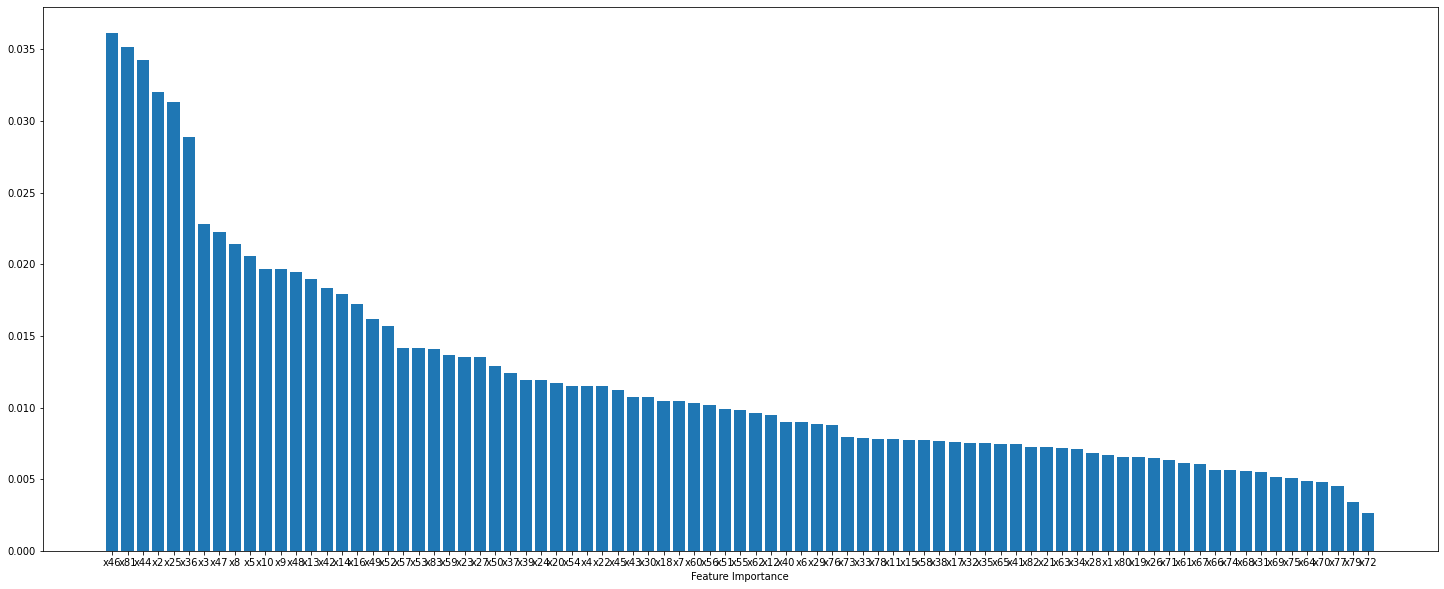

In [ ]:
plt.figure(figsize=(25,10))
plt.bar(baseline_rf_feat_importances.index, baseline_rf_feat_importances['importance'])
plt.xlabel('Feature Importance')

The feature importance tapers off at about 0.0125. Let's take a look at the features with importances of at least 0.0125.

Text(0.5, 0, 'Feature Importance')

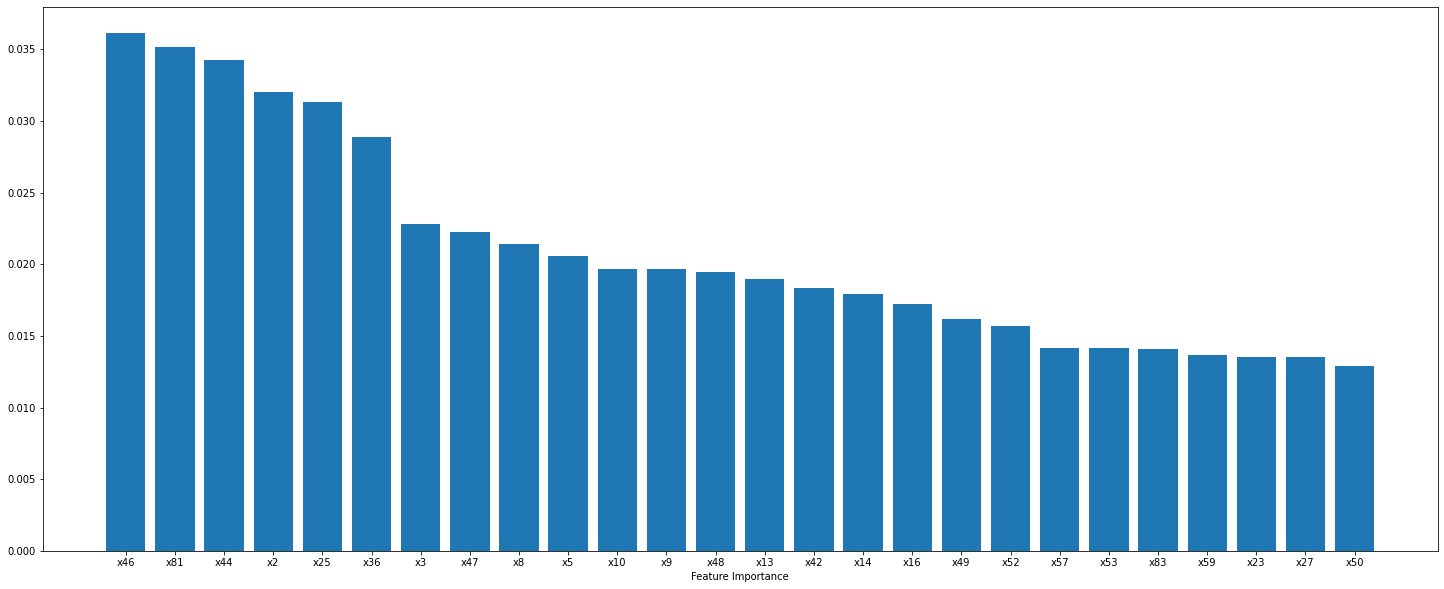

In [ ]:
plt.figure(figsize=(25,10))

sub_baseline_rf_feat_importances = baseline_rf_feat_importances[
    baseline_rf_feat_importances['importance'] >= 0.0125
]

plt.bar(sub_baseline_rf_feat_importances.index, sub_baseline_rf_feat_importances['importance'])
plt.xlabel('Feature Importance')

In [ ]:
print(sub_baseline_rf_feat_importances.index)
print(len(sub_baseline_rf_feat_importances.index))

Index(['x46', 'x81', 'x44', 'x2', 'x25', 'x36', 'x3', 'x47', 'x8', 'x5', 'x10',
       'x9', 'x48', 'x13', 'x42', 'x14', 'x16', 'x49', 'x52', 'x57', 'x53',
       'x83', 'x59', 'x23', 'x27', 'x50'],
      dtype='object')
26


At this juncture, the above 26 features are some of the more important features. We shall for the moment just keep the shape of the feature importance graph of the 26 features in mind.

## Preprocessing II

Due to the imbalance of data, we shall attempt oversampling of the minority class and undersampling our majority class. Our strategy here will be to combine oversampling using Synthetic Minority Oversampling Technique (SMOTE) and undersampling using Edited Nearest Neighbors Undersampling (ENN).

https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/#:~:text=Oversampling%20methods%20duplicate%20or%20create,of%20methods%20are%20used%20together.

In [ ]:
# SMOTEENN is a class that performs over-sampling using SMOTE and cleaning using ENN

resample = SMOTEENN(smote=SMOTE(sampling_strategy=0.50),enn=EditedNearestNeighbours(sampling_strategy='majority'))

## Modelling I


### Random Forest II

We again attempt random forest on the data with resampling. This time, we will also be using `RandomSearchCV` to tune the hyperparameters. We hope to see improvements in the performance metric.

In [ ]:
rf_model = RandomForestClassifier(n_jobs=-1)

In [ ]:
rf_imb_pipeline = ImbPipeline([
    ('drop_company_and_time_columns', drop_coy_and_time),
    ('std_scaler', std_scaler),
    ('resampling', resample),
    ('rf_model', rf_model)
])

In [ ]:
rf_param_grid = {
    'rf_model__n_estimators' : [100],
    'rf_model__max_depth' : [2,5,10,None],
    'rf_model__max_features' : [0.25,0.5,0.75,1,None],
    'rf_model__min_samples_leaf' : [4,8,12,16]
}

In [ ]:
# RepeatedStratifiedKFold is used here due to the imbalance of data

strat_cv = RepeatedStratifiedKFold(n_splits=3,n_repeats=3,random_state=24)

In [ ]:
rf_random_search = RandomizedSearchCV(
    rf_imb_pipeline, rf_param_grid, cv=strat_cv,n_jobs=-1,
    scoring='recall', return_train_score=True, verbose=2,
    n_iter = 10, random_state=24
)

In [ ]:
# Random Search
# %timeit rf_random_search.fit(x_train, y_train)

In [ ]:
# print(rf_random_search.best_params_)
# print(rf_random_search.best_score_)

From the random search, we observe that the best parameters are:

- `max_depth` of None
- `max_features` of 0.25
- `min_samples_leaf` of 16


In [ ]:
best_rf_model1 = RandomForestClassifier(n_estimators=100,max_depth=None,max_features=0.25,min_samples_leaf=16)

In [ ]:
best_rf_model1_imb_pipeline = ImbPipeline([
    ('drop_company_and_time_columns', drop_coy_and_time),
    ('std_scaler', std_scaler),
    ('resampling', resample),
    ('best_rf_model1', best_rf_model1)
])

`ImbPipeline` is imported from the `ImbLearn` library to handle imbalanced data. Specifically, the resampling works in the `ImbPipeline` but not the usual `SKLearn` pipeline. 

In [ ]:
best_rf_model1_imb_pipeline.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=F

Pipeline(memory=None,
         steps=[('drop_company_and_time_columns', DropCompanyAndTime()),
                ('std_scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('resampling',
                 SMOTEENN(enn=EditedNearestNeighbours(kind_sel='all', n_jobs=1,
                                                      n_neighbors=3,
                                                      random_state=None,
                                                      ratio=None,
                                                      return_indices=False,
                                                      sampling_strategy='majority'),
                          random_state=None, ratio=None...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features=0.25,
                                    

In [ ]:
best_rf_model1_y_train_preds = best_rf_model1_imb_pipeline.predict(x_train)
best_rf_model1_y_val_preds = best_rf_model1_imb_pipeline.predict(x_val)

Training Recall Score: 0.9253731343283582
Training F1 Score: 0.5
Training ROC AUC Score: 0.928333218434387


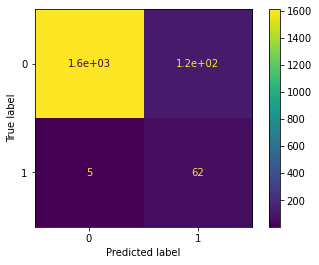

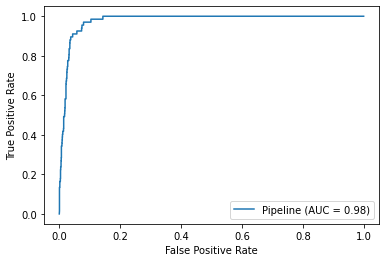

In [ ]:
print("Training Recall Score:", recall_score(y_train,best_rf_model1_y_train_preds))
print("Training F1 Score:", f1_score(y_train,best_rf_model1_y_train_preds))
print("Training ROC AUC Score:", roc_auc_score(y_train,best_rf_model1_y_train_preds))
plot_confusion_matrix(best_rf_model1_imb_pipeline, x_train,y_train)
plot_roc_curve(best_rf_model1_imb_pipeline, x_train,y_train)

Validation Recall Score: 0.7142857142857143
Validation F1 Score: 0.37037037037037035
Validation ROC AUC Score: 0.8167660065372044


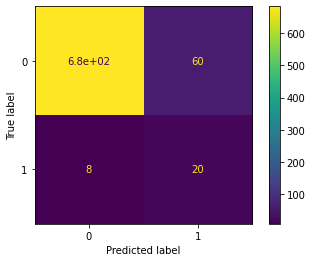

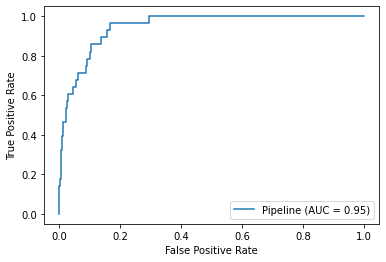

In [ ]:
print("Validation Recall Score:", recall_score(y_val,best_rf_model1_y_val_preds))
print("Validation F1 Score:", f1_score(y_val,best_rf_model1_y_val_preds))
print("Validation ROC AUC Score:", roc_auc_score(y_val,best_rf_model1_y_val_preds))
plot_confusion_matrix(best_rf_model1_imb_pipeline, x_val,y_val)
plot_roc_curve(best_rf_model1_imb_pipeline, x_val, y_val)

After resampling and parameter tuning, we see a good all-round improvement in our performance metrics. In particular, the validation recall score drastically improved from 0.107 to 0.714. The ROC AUC Score also saw a large improvement from 0.554 to 0.817. There is a remarkable decrease in number of false positives.

#### Feature Importance II

In [ ]:
best_rf_model1_feat_importances = pd.DataFrame(best_rf_model1.feature_importances_,
                                        index=x_train.columns[2:],
                                        columns=['importance']).sort_values('importance',
                                        ascending=False)

Text(0.5, 0, 'Feature Importance')

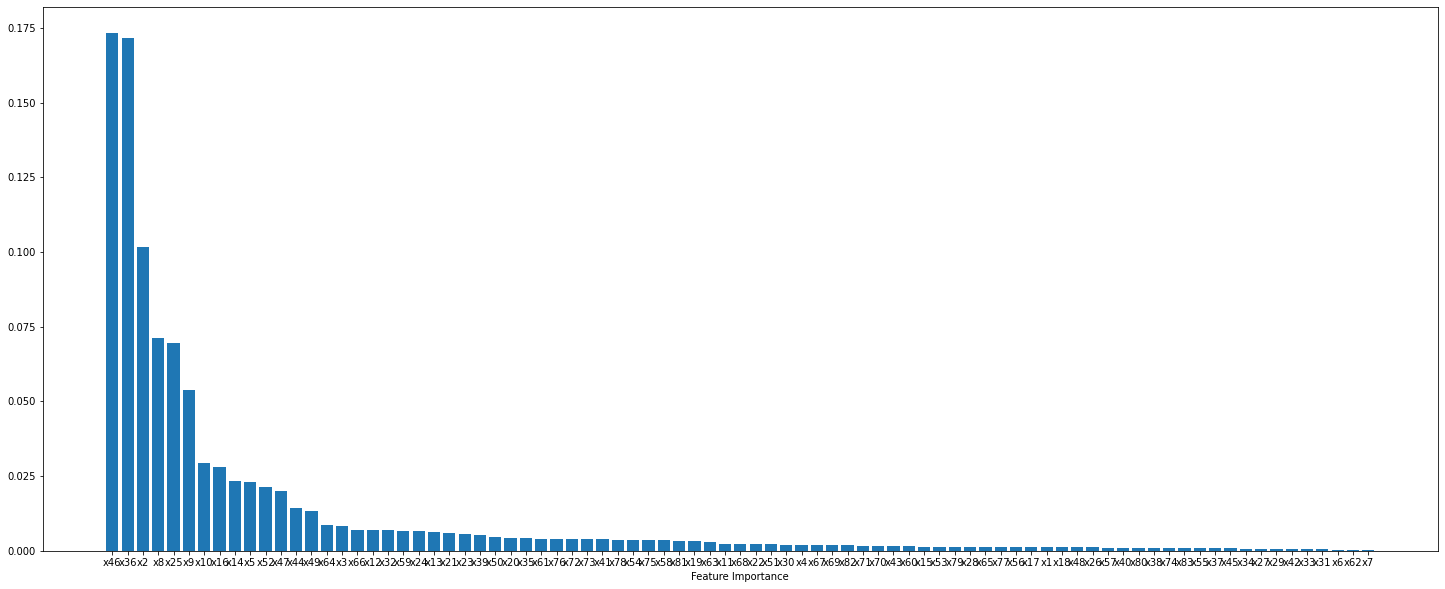

In [ ]:
plt.figure(figsize=(25,10))
plt.bar(best_rf_model1_feat_importances.index, best_rf_model1_feat_importances['importance'])
plt.xlabel('Feature Importance')

After resampling, it is evident that the feature importance seem to "decay" a much faster rate. There is now a clearer distinction between the features with more importance and those with less. The random forest is now more able to identify which features are much more important than the others.

Let's again take 0.0125 to be our cut-off.

14


Text(0.5, 0, 'Feature Importance')

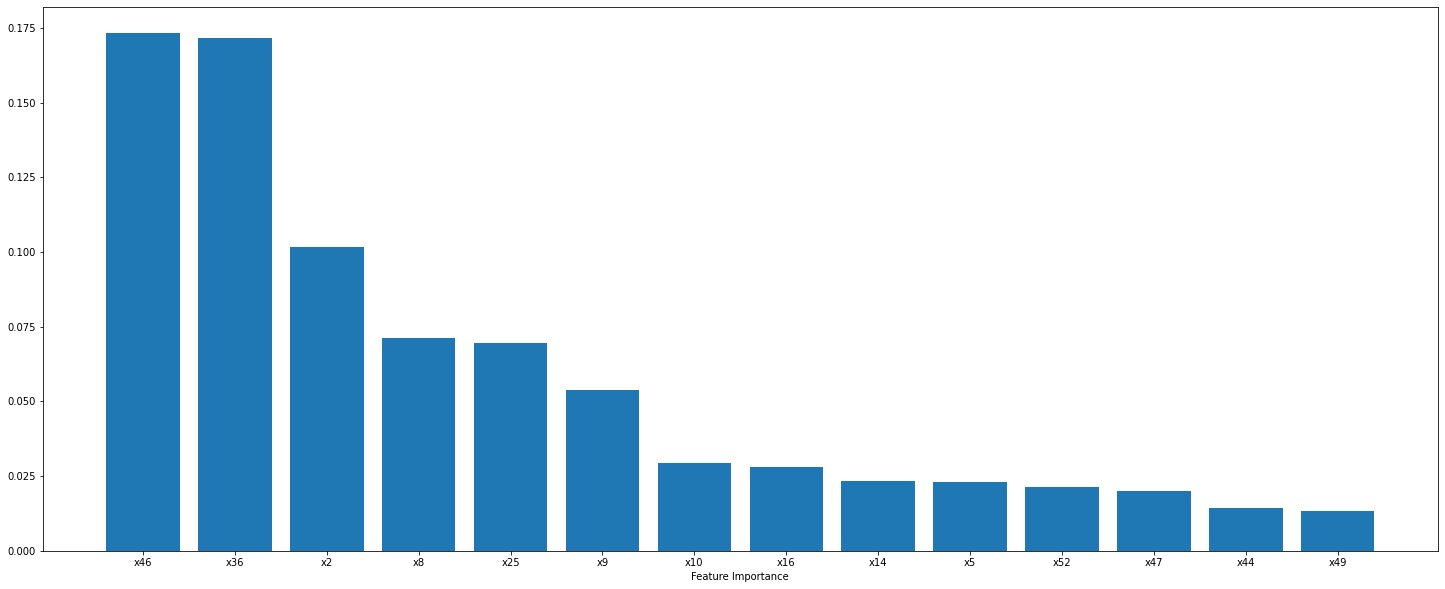

In [ ]:
plt.figure(figsize=(25,10))

sub_best_rf_model1_feat_importances = best_rf_model1_feat_importances[
    best_rf_model1_feat_importances['importance'] >= 0.0125
]
print(len(sub_best_rf_model1_feat_importances.index))
plt.bar(sub_best_rf_model1_feat_importances.index, sub_best_rf_model1_feat_importances['importance'])
plt.xlabel('Feature Importance')

There are now only 14 features with feature importance above 0.0125, with 2 of them having distinctly high feature importance score. 14 features is much lesser than before resampling at the same cut off of 0.0125.

## Preprocessing III

Based on the feature importance, we shall only include some of the more important features. We shall also check for collinearity between the features, and to remove features that are correlated to one another.

In [ ]:
list_of_impt_feat = sub_best_rf_model1_feat_importances.index.tolist()
print(list_of_impt_feat)

['x46', 'x36', 'x2', 'x8', 'x25', 'x9', 'x10', 'x16', 'x14', 'x5', 'x52', 'x47', 'x44', 'x49']


In [ ]:
temp_df = x_train[list_of_impt_feat]

In [ ]:
temp_corr = temp_df.corr()
temp_corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,x46,x36,x2,x8,x25,x9,x10,x16,x14,x5,x52,x47,x44,x49
x46,1.00,0.34,0.46,-0.00,0.26,0.20,0.44,-0.00,-0.18,0.33,-0.00,-0.01,0.83,-0.18
x36,0.34,1.00,0.82,0.09,0.51,0.63,0.58,-0.04,-0.31,0.72,-0.04,-0.03,0.05,-0.33
x2,0.46,0.82,1.00,-0.00,0.68,0.73,0.74,0.01,-0.38,0.90,0.01,-0.04,0.10,-0.37
x8,-0.00,0.09,-0.00,1.00,-0.01,0.01,-0.02,-0.73,0.00,-0.04,-0.72,-0.00,-0.00,-0.01
x25,0.26,0.51,0.68,-0.01,1.00,0.62,0.53,0.02,-0.12,0.65,0.02,-0.03,0.05,-0.11
x9,0.20,0.63,0.73,0.01,0.62,1.00,0.31,0.01,-0.15,0.69,0.01,-0.05,0.03,-0.13
x10,0.44,0.58,0.74,-0.02,0.53,0.31,1.00,0.02,-0.46,0.65,0.02,-0.02,0.13,-0.45
x16,-0.00,-0.04,0.01,-0.73,0.02,0.01,0.02,1.00,0.01,0.05,1.00,0.00,0.00,0.02
x14,-0.18,-0.31,-0.38,0.00,-0.12,-0.15,-0.46,0.01,1.00,-0.28,0.01,0.07,-0.04,0.98
x5,0.33,0.72,0.90,-0.04,0.65,0.69,0.65,0.05,-0.28,1.00,0.05,-0.02,0.03,-0.26


From the correlation plot above, we observe that the following features are highly correlated:

- `x2` and `x5` at 0.90
- `x46` and `x44` at 0.83
- `x2` and `x10` at 0.74
- `x2` and `x36` at 0.82
- `x2` and `x9` at 0.73
- `x5` and `x36` at 0.72
- `x52` and `x16` at 1
- `x14`and `x49` at 0.98
- `x52` and `x8` at -0.72
- `x16` and `x8` at -0.73

We observe that `x2` is correlated with many other variables. Therefore, we shall remove `x2`. 

We will also remove `x5`, `x16`, `x44`, `x52`, `x49` for being correlated with other variables while having relatively lower feature importance scores.

In [ ]:
list_of_impt_feat2 = ['x36', 'x46', 'x8', 'x9', 'x25', 'x10', 'x47', 'x14', 'x64']
print(list_of_impt_feat2)
print(len(list_of_impt_feat2))

['x36', 'x46', 'x8', 'x9', 'x25', 'x10', 'x47', 'x14', 'x64']
9


There are now 9 remaining variables. Let's take a look at the correlation matrix after removing some of the correlated variables.

In [ ]:
temp_df2 = x_train[list_of_impt_feat2]

temp_corr2 = temp_df2.corr()
temp_corr2.style.background_gradient(cmap='coolwarm').set_precision(2)

,x36,x46,x8,x9,x25,x10,x47,x14,x64
x36,1.00,0.34,0.09,0.63,0.51,0.58,-0.03,-0.31,-0.00
x46,0.34,1.00,-0.00,0.20,0.26,0.44,-0.01,-0.18,-0.06
x8,0.09,-0.00,1.00,0.01,-0.01,-0.02,-0.00,0.00,-0.01
x9,0.63,0.20,0.01,1.00,0.62,0.31,-0.05,-0.15,0.14
x25,0.51,0.26,-0.01,0.62,1.00,0.53,-0.03,-0.12,-0.06
x10,0.58,0.44,-0.02,0.31,0.53,1.00,-0.02,-0.46,-0.29
x47,-0.03,-0.01,-0.00,-0.05,-0.03,-0.02,1.00,0.07,-0.06
x14,-0.31,-0.18,0.00,-0.15,-0.12,-0.46,0.07,1.00,0.10
x64,-0.00,-0.06,-0.01,0.14,-0.06,-0.29,-0.06,0.10,1.00


The remaining 9 variables are very much less correlated with one another.

In [ ]:
class OnlyRFImptFeat(BaseEstimator, TransformerMixin):

  def __init__(self):
    self.new_df = None

  def fit(self, x, y=None):
    return self

  def transform(self, x , y=None):
    x2 = x[['x36', 'x46', 'x8', 'x9', 'x25', 'x10', 'x47', 'x14', 'x64']]
    self.new_df = x2
    return x2

In [ ]:
only_rf_impt_feat = OnlyRFImptFeat()

## Modelling II

In part II of modelling, we will repeat using the same learning methods we had in Modelling I, except that we will be training on only selected features from Preprocessing III. We will also be looking at more learning methods.

### Random Forest III

In [ ]:
rf_imb_pipeline2 = ImbPipeline([
    ('drop_company_and_time_columns', drop_coy_and_time),
    ('only_rf_impt_feat', only_rf_impt_feat),
    ('std_scaler', std_scaler),
    ('resampling', resample),
    ('rf_model', rf_model)
])

In [ ]:
rf_random_search2 = RandomizedSearchCV(
    rf_imb_pipeline2, rf_param_grid, cv=strat_cv,n_jobs=-1,
    scoring='recall', return_train_score=True, verbose=2,
    n_iter = 10, random_state=24
)

In [ ]:
# %timeit rf_random_search2.fit(x_train, y_train)

In [ ]:
# print(rf_random_search2.best_params_)
# print(rf_random_search2.best_score_)

From the random search, we observe that the best parameters for our random forest model are:

- `max_depth` of 5
- `max_features` of 0.25
- `min_samples_leaf` of 16

In [ ]:
best_rf_model2 = RandomForestClassifier(n_estimators=100,max_depth=5,max_features=0.25,min_samples_leaf=16)

In [ ]:
best_rf_model2_imb_pipeline = ImbPipeline([
    ('drop_company_and_time_columns', drop_coy_and_time),
    ('only_rf_impt_feat', only_rf_impt_feat),
    ('std_scaler', std_scaler),
    ('resampling', resample),
    ('best_rf_model2', best_rf_model2)
])

In [ ]:
best_rf_model2_imb_pipeline.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=F

Pipeline(memory=None,
         steps=[('drop_company_and_time_columns', DropCompanyAndTime()),
                ('only_rf_impt_feat', OnlyRFImptFeat()),
                ('std_scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('resampling',
                 SMOTEENN(enn=EditedNearestNeighbours(kind_sel='all', n_jobs=1,
                                                      n_neighbors=3,
                                                      random_state=None,
                                                      ratio=None,
                                                      return_indices=False,
                                                      sampling_strategy='...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=5, max_features=0.25,
                                        max_leaf_

In [ ]:
best_rf_model2_y_train_preds = best_rf_model2_imb_pipeline.predict(x_train)
best_rf_model2_y_val_preds = best_rf_model2_imb_pipeline.predict(x_val)

Training Recall Score: 0.8805970149253731
Training F1 Score: 0.38187702265372164
Training ROC AUC Score: 0.8874694081555272


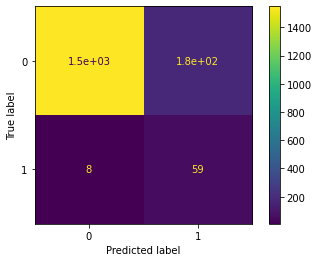

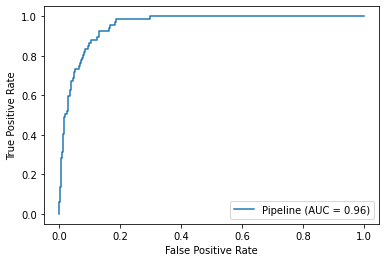

In [ ]:
print("Training Recall Score:", recall_score(y_train,best_rf_model2_y_train_preds))
print("Training F1 Score:", f1_score(y_train,best_rf_model2_y_train_preds))
print("Training ROC AUC Score:", roc_auc_score(y_train,best_rf_model2_y_train_preds))
plot_confusion_matrix(best_rf_model2_imb_pipeline, x_train,y_train)
plot_roc_curve(best_rf_model2_imb_pipeline, x_train,y_train)

Validation Recall Score: 0.7857142857142857
Validation F1 Score: 0.3548387096774194
Validation ROC AUC Score: 0.843059027110171


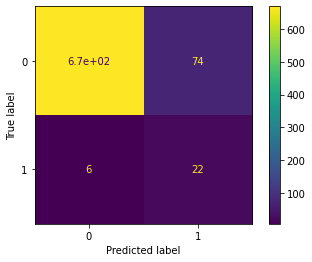

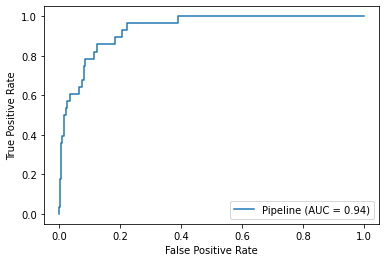

In [ ]:
print("Validation Recall Score:", recall_score(y_val,best_rf_model2_y_val_preds))
print("Validation F1 Score:", f1_score(y_val,best_rf_model2_y_val_preds))
print("Validation ROC AUC Score:", roc_auc_score(y_val,best_rf_model2_y_val_preds))
plot_confusion_matrix(best_rf_model2_imb_pipeline, x_val,y_val)
plot_roc_curve(best_rf_model2_imb_pipeline, x_val, y_val)

After feature selection, our validation recall score (0.714 to 0.786) and validation ROC AUC score (0.817 to 0.843) improved. However, our F1 score has decreased slightly (0.370 to 0.354), due to a fall in precision.

From the confusion matrix, the model is able to predict more true positives than before, from 20 to 22 out of 28.

Nonetheless, this is a good general improvement, and we are more concerned with recall than with precision. Furthermore, using 9 variables may allow us to generalize better.

#### Feature Importance

In [ ]:
best_rf_model2_feat_importances = pd.DataFrame(best_rf_model2.feature_importances_,
                                        index=list_of_impt_feat2,
                                        columns=['importance']).sort_values('importance',
                                        ascending=False)

Text(0.5, 0, 'Feature Importance')

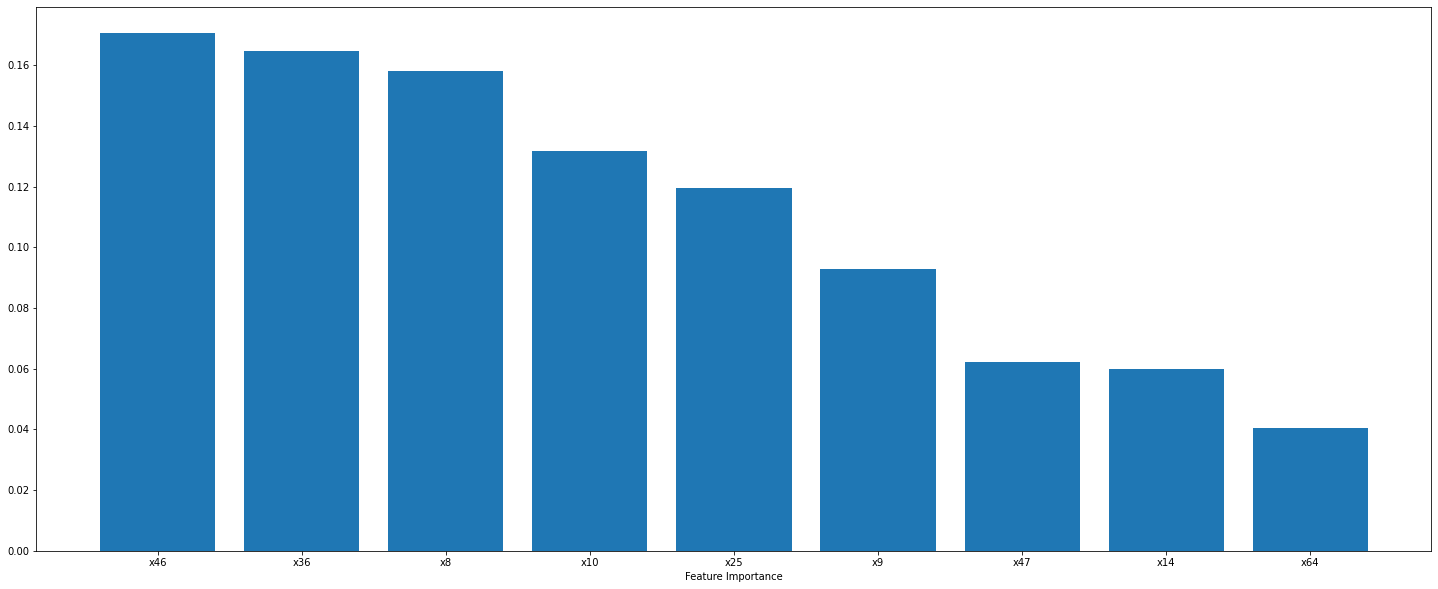

In [ ]:
plt.figure(figsize=(25,10))
plt.bar(best_rf_model2_feat_importances.index, best_rf_model2_feat_importances['importance'])
plt.xlabel('Feature Importance')

#### Threshold-Moving

Here, we shall attempt to lower the decision thresholds to allow the model to accept more predictions to be positive, since false negatives can be very costly.

A precision-recall curve focuses on the performance of a classifier on the positive (minority class). 

Let's use the F1 score to decide our optimal decision threshold

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/#:~:text=ROC%20Curves%20summarize%20the%20trade,model%20using%20different%20probability%20thresholds.&text=ROC%20curves%20are%20appropriate%20when,are%20appropriate%20for%20imbalanced%20datasets.


https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/


In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):

  plt.figure(figsize=(8,8))
  plt.title("Precision and Recall Scores as a function of the decision threshold")
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1],"g--", label="Recall")
  plt.ylabel("Score")
  plt.xlabel("Decision Threshold")
  plt.legend(loc='best')

In [ ]:
best_rf_model2_y_train_probs = best_rf_model2_imb_pipeline.predict_proba(x_train)
best_rf_model2_y_val_probs = best_rf_model2_imb_pipeline.predict_proba(x_val)

In [ ]:
best_rf_model2_y_train_probs = best_rf_model2_y_train_probs[:,1]
best_rf_model2_y_val_probs = best_rf_model2_y_val_probs[:,1]

In [ ]:
# Calculate Precision-Recall Curve
train_precision, train_recall, train_thresholds = precision_recall_curve(y_train, best_rf_model2_y_train_probs)

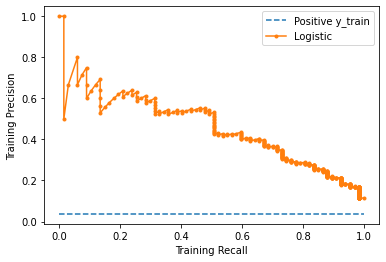

In [ ]:
pos_y_train = len(y_train[y_train['Financial Distress'] == 1]) / len(y_train.index)
plt.plot([0,1],[pos_y_train,pos_y_train], linestyle='--', label='Positive y_train')
plt.plot(train_recall,train_precision,marker='.', label='Logistic')
plt.xlabel('Training Recall')
plt.ylabel('Training Precision')
plt.legend()
plt.show()

In [ ]:
train_fscore = (2 * train_precision * train_recall) / (train_precision + train_recall)
ix = argmax(train_fscore)
print('Best Threshold=%f, F-Score=%.3f, Recall Score=%.3f' % (train_thresholds[ix], train_fscore[ix], train_recall[ix]))

Best Threshold=0.952124, F-Score=0.519, Recall Score=0.507


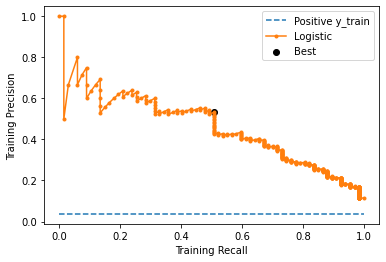

In [ ]:
pos_y_train = len(y_train[y_train['Financial Distress'] == 1]) / len(y_train.index)
plt.plot([0,1],[pos_y_train,pos_y_train], linestyle='--', label='Positive y_train')
plt.plot(train_recall,train_precision,marker='.', label='Logistic')
plt.scatter(train_recall[ix], train_precision[ix], marker='o', color='black',label='Best')
plt.xlabel('Training Recall')
plt.ylabel('Training Precision')
plt.legend()
plt.show()

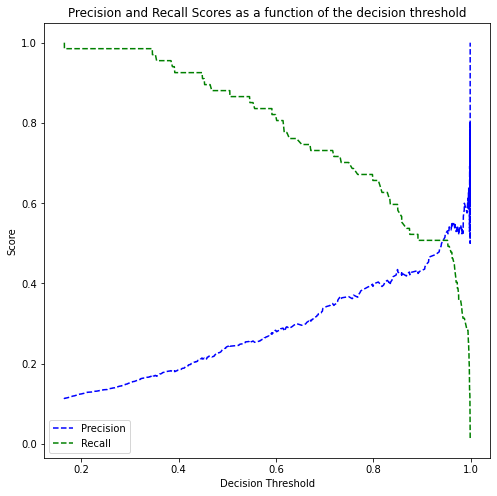

In [ ]:
plot_precision_recall_vs_threshold(train_precision, train_recall, train_thresholds)

In this section, we found that the optimal f1 score is at a decision threshold of about 0.9.

The decision threshold currently is at the default of 0.5. We should not lower it anymore as it will severely compromise our precision. However, we should not aim to raise it to optimize the f1 score as it will severely hurt our recall score which, in our case, is our main performance metric and can be very costly for the companies should we predict more false negatives.

Therefore, the decision threshold shall not be moved, and will remain at 0.5.

In [ ]:
val_precision, val_recall, val_thresholds = precision_recall_curve(y_val, best_rf_model2_y_val_probs)
val_fscore = (2 * val_precision * val_recall) / (val_precision + val_recall)
ix = argmax(val_fscore)
print('Best Threshold=%f, F-Score=%.3f, Recall Score=%.3f' % (val_thresholds[ix], val_fscore[ix], val_recall[ix]))

Best Threshold=0.897926, F-Score=0.519, Recall Score=0.500


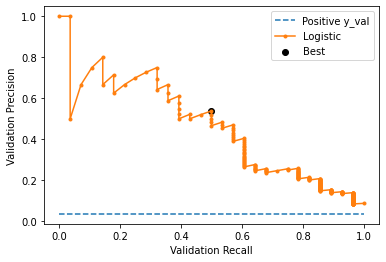

In [ ]:
pos_y_val = len(y_val[y_val['Financial Distress'] == 1]) / len(y_val.index)
plt.plot([0,1],[pos_y_val,pos_y_val], linestyle='--', label='Positive y_val')
plt.plot(val_recall,val_precision,marker='.', label='Logistic')
plt.scatter(val_recall[ix], val_precision[ix], marker='o', color='black',label='Best')
plt.xlabel('Validation Recall')
plt.ylabel('Validation Precision')
plt.legend()
plt.show()

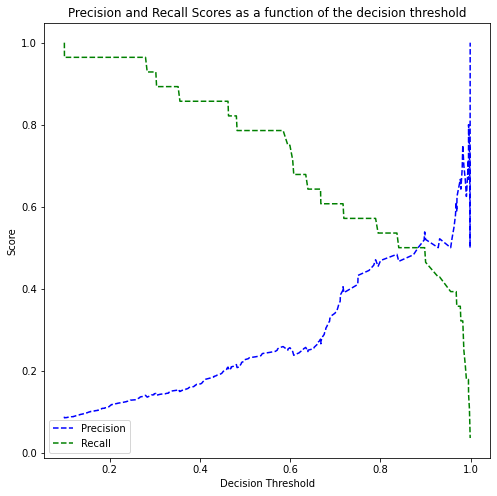

In [ ]:
plot_precision_recall_vs_threshold(val_precision, val_recall, val_thresholds)

The observations from the validation set is similar to that of the training set.

### Support Vector Machine (Radial Basis Function kernel (RBF Kernel))

In [ ]:
svc_model = SVC() # Radial Basis Function Kernel by default

In [ ]:
svc_pipeline = ImbPipeline([
    ('drop_company_and_time_columns', drop_coy_and_time),
    ('only_rf_impt_feat', only_rf_impt_feat),
    ('std_scaler', std_scaler),
    ('resampling', resample),
    ('svc_model', svc_model)
])

In [ ]:
svc_param_grid = {
    'svc_model__C' : [0.001,0.005,0.01,0.05,0.1,0.5,1],
    'svc_model__gamma' : [0.001,0.005,0.01,0.05,0.1,0.5,10,25,50,75,100,'scale']
}

In [ ]:
svc_random_search = RandomizedSearchCV(
    svc_pipeline, svc_param_grid, cv=strat_cv,n_jobs=-1,
    scoring='recall', return_train_score=True, verbose=2,
    n_iter = 10, random_state=24
)

In [ ]:
# %timeit svc_random_search.fit(x_train, y_train)

In [ ]:
# print(svc_random_search.best_params_)
# print(svc_random_search.best_score_)

From the random search, we observe that the best parameters for our Radial Basis Function Kernel SVM are:

- `gamma` of 0.05
- `C` of 1

In [ ]:
best_svc_model = SVC(C=1,gamma=0.05)

In [ ]:
best_svc_pipeline = ImbPipeline([
    ('drop_company_and_time_columns', drop_coy_and_time),
    ('only_rf_impt_feat', only_rf_impt_feat),
    ('std_scaler', std_scaler),
    ('resampling', resample),
    ('best_svc_model', best_svc_model)
])

In [ ]:
best_svc_pipeline.fit(x_train,y_train)

best_svc_model_y_train_preds = best_svc_pipeline.predict(x_train)
best_svc_model_y_val_preds = best_svc_pipeline.predict(x_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=F

Training Recall Score: 0.8208955223880597
Training F1 Score: 0.3481012658227848
Training ROC AUC Score: 0.8544431422563855


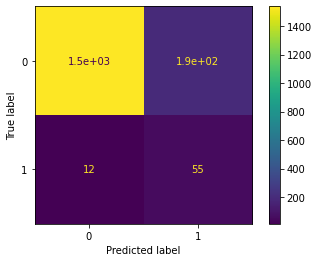

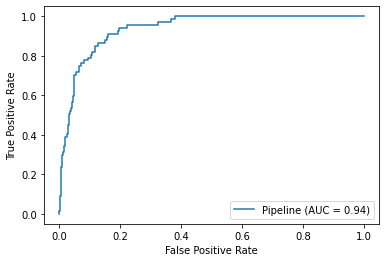

In [ ]:
print("Training Recall Score:", recall_score(y_train,best_svc_model_y_train_preds))
print("Training F1 Score:", f1_score(y_train,best_svc_model_y_train_preds))
print("Training ROC AUC Score:", roc_auc_score(y_train,best_svc_model_y_train_preds))
plot_confusion_matrix(best_svc_pipeline, x_train,y_train)
plot_roc_curve(best_svc_pipeline, x_train,y_train)

Validation Recall Score: 0.8571428571428571
Validation F1 Score: 0.36923076923076925
Validation ROC AUC Score: 0.87608152278408


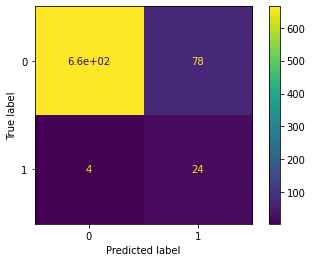

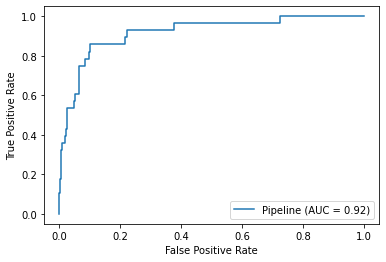

In [ ]:
print("Validation Recall Score:", recall_score(y_val,best_svc_model_y_val_preds))
print("Validation F1 Score:", f1_score(y_val,best_svc_model_y_val_preds))
print("Validation ROC AUC Score:", roc_auc_score(y_val,best_svc_model_y_val_preds))
plot_confusion_matrix(best_svc_pipeline, x_val,y_val)
plot_roc_curve(best_svc_pipeline, x_val, y_val)

The performance metrics improved drastically in this RBF SVC as compared to the baseline RBF SVC.

- Validation `recall` score increased from 0 to 0.857
- Validation `f1` score increased from 0 to 0.369
- Validation `roc_auc` score increased from 0.5 to 0.876

The number of true positives has also increased from 0 to 24 out of 28. Additionally, this RBF SVC model performed better in all departments than our current best random forest.

### LightGBM

LightGBM is a state-of-the-art boosting method.

In [ ]:
lgb_model = lgb.LGBMClassifier()

In [ ]:
lgb_imb_pipeline = ImbPipeline([
    ('drop_company_and_time_columns', drop_coy_and_time),
    ('only_rf_impt_feat', only_rf_impt_feat),
    ('std_scaler', std_scaler),
    ('resampling', resample),
    ('lgb_model', lgb_model)
])

In [ ]:
lgb_param_grid = {
    'lgb_model__learning_rate' : [0.025,0.05,0.075,0.1],
    'lgb_model__n_estimators' : [100,150,200,250,300],
    'lgb_model__num_leaves' : [10,20,30,31,40,50],
    'lgb_model__min_data_in_leaf' : [25,50,75,100,125,150],
    'lgb_model__max_depth' : [5,10,15,20,25],
}

In [ ]:
lgb_random_search = RandomizedSearchCV(
    lgb_imb_pipeline, lgb_param_grid, cv=strat_cv,n_jobs=-1,
    scoring='neg_mean_squared_error', return_train_score=True, verbose=2,
    n_iter = 15, random_state=24
)

In [ ]:
# %timeit lgb_random_search.fit(x_train, y_train)

In [ ]:
# print(lgb_random_search.best_params_)
# print(lgb_random_search.best_score_)

From the random search, we observe that the best parameters for our LightGBM are:

- `num_leaves` of 50
- `n_estimators` of 250
- `min_data_in_leaf` of 50
- `max_depth` of 25
- `learning_rate` of 0.1

In [ ]:
best_lgb_model = lgb.LGBMClassifier(n_estimators=250, learning_rate = 0.1, num_leaves=50, min_data_in_leaf=50, max_depth=25)

In [ ]:
best_lgb_imb_pipeline = ImbPipeline([
    ('drop_company_and_time_columns', drop_coy_and_time),
    ('only_rf_impt_feat', only_rf_impt_feat),
    ('std_scaler', std_scaler),
    ('resampling', resample),
    ('best_lgb_model', best_lgb_model)
])

In [ ]:
best_lgb_imb_pipeline.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=F

Pipeline(memory=None,
         steps=[('drop_company_and_time_columns', DropCompanyAndTime()),
                ('only_rf_impt_feat', OnlyRFImptFeat()),
                ('std_scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('resampling',
                 SMOTEENN(enn=EditedNearestNeighbours(kind_sel='all', n_jobs=1,
                                                      n_neighbors=3,
                                                      random_state=None,
                                                      ratio=None,
                                                      return_indices=False,
                                                      sampling_strategy='...
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=25,
                                min_child_samples=20

In [ ]:
best_lgb_model_y_train_preds = best_lgb_imb_pipeline.predict(x_train)
best_lgb_model_y_val_preds = best_lgb_imb_pipeline.predict(x_val)

Training Recall Score: 1.0
Training F1 Score: 0.4962962962962963
Training ROC AUC Score: 0.9607390300230947


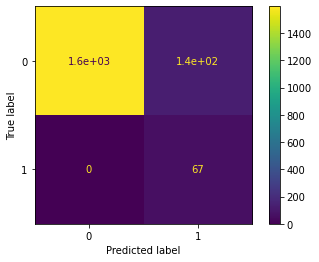

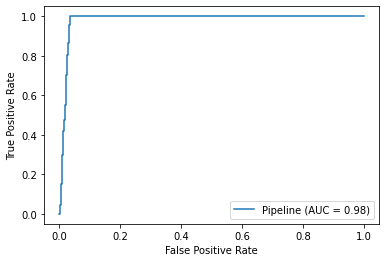

In [ ]:
print("Training Recall Score:", recall_score(y_train,best_lgb_model_y_train_preds))
print("Training F1 Score:", f1_score(y_train,best_lgb_model_y_train_preds))
print("Training ROC AUC Score:", roc_auc_score(y_train,best_lgb_model_y_train_preds))
plot_confusion_matrix(best_lgb_imb_pipeline, x_train,y_train)
plot_roc_curve(best_lgb_imb_pipeline, x_train,y_train)

Validation Recall Score: 0.6071428571428571
Validation F1 Score: 0.3177570093457944
Validation ROC AUC Score: 0.7618486829455875


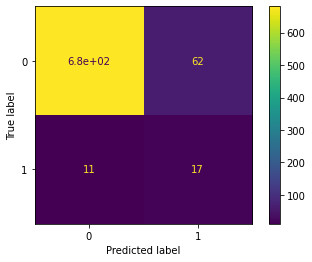

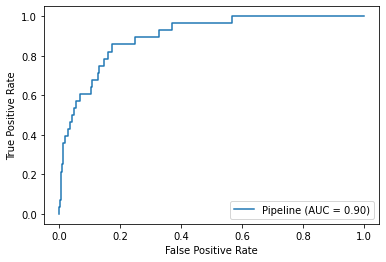

In [ ]:
print("Validation Recall Score:", recall_score(y_val,best_lgb_model_y_val_preds))
print("Validation F1 Score:", f1_score(y_val,best_lgb_model_y_val_preds))
print("Validation ROC AUC Score:", roc_auc_score(y_val,best_lgb_model_y_val_preds))
plot_confusion_matrix(best_lgb_imb_pipeline, x_val,y_val)
plot_roc_curve(best_lgb_imb_pipeline, x_val, y_val)

Clearly, our lightGBM has overfitted the training data. It achieved a perfect training recall score and a high training ROC AUC score of 0.960. However, the validation recall score is only 0.607 and the validation ROC AUC score is 0.761.

## Test the data

Our RBF SVC performed the best on the validation set. Therefore, we shall use it as our final model to be tested on the test set.

In [ ]:
testing_svc_model = SVC(C=1,gamma=0.05)

In [ ]:
# Concatenate the training and validation set to form a bigger training set

x_train_concat = pd.concat([x_train,x_val], axis=0)
y_train_concat = pd.concat([y_train, y_val], axis = 0)

In [ ]:
# Pipeline

svc_test_pipeline = ImbPipeline([
    ('drop_company_and_time_columns', drop_coy_and_time),
    ('only_rf_impt_feat', only_rf_impt_feat),
    ('std_scaler', std_scaler),
    ('resampling', resample),
    ('svc_model', svc_model)
])

In [ ]:
svc_test_pipeline.fit(x_train_concat, y_train_concat)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=F

Pipeline(memory=None,
         steps=[('drop_company_and_time_columns', DropCompanyAndTime()),
                ('only_rf_impt_feat', OnlyRFImptFeat()),
                ('std_scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('resampling',
                 SMOTEENN(enn=EditedNearestNeighbours(kind_sel='all', n_jobs=1,
                                                      n_neighbors=3,
                                                      random_state=None,
                                                      ratio=None,
                                                      return_indices=False,
                                                      sampling_strategy='...
                                      out_step='deprecated', random_state=None,
                                      ratio=None, sampling_strategy=0.5,
                                      svm_estimator='deprecated'))),
                ('svc_model',
                 

In [ ]:
svc_y_test_preds = svc_test_pipeline.predict(x_test)

Test Recall Score: 0.8780487804878049
Test F1 Score: 0.33962264150943394
Test ROC AUC Score: 0.8754051630996987


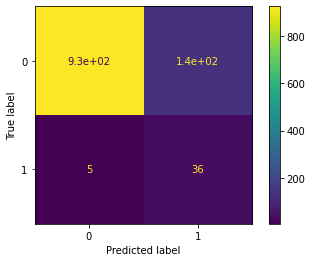

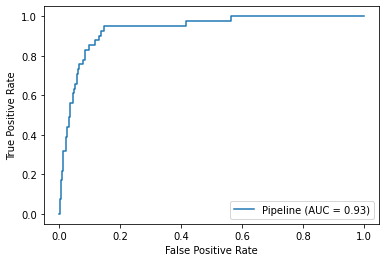

In [ ]:
print("Test Recall Score:", recall_score(y_test,svc_y_test_preds))
print("Test F1 Score:", f1_score(y_test,svc_y_test_preds))
print("Test ROC AUC Score:", roc_auc_score(y_test,svc_y_test_preds))
plot_confusion_matrix(svc_test_pipeline, x_test,y_test)
plot_roc_curve(svc_test_pipeline, x_test, y_test)

The RBF SVC performed remarkably well despite the extreme skew of the data. The test recall score and ROC AUC score are impressive at 0.878 and 0.875 respectively. 36 out of 41 financially distressed companies are correctly predicted.